<a href="https://colab.research.google.com/github/jnsbrdbr/hopefully_last_thesis/blob/main/1118_gaussian13214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

In [ ]:
with open('/content/drive/MyDrive/10000/Tresult.pkl', "rb") as fh:
  result = pickle.load(fh)

In [ ]:
#divide data in to data_label and non_data label

y=result.label
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(y)):
  if y[i]==1:
    y[i]=0
  else:
    y[i]=1

In [ ]:
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel

In [ ]:
#SMOTE

sm = SMOTE(sampling_strategy=1,k_neighbors=10)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

In [ ]:
#The model

model=svm.SVC(kernel="rbf",gamma=0.1, C=0.1, probability=True)

In [ ]:
#FPR
from sklearn.metrics import confusion_matrix
import sys
import numpy

kf = KFold(n_splits=10,shuffle=True)#, random_state=None
res_fpr = list()
res_probas_=list()
Y_test_lst=list()
pred_values_lst=list()

for train_index , test_index in kf.split(X_train_oversampled,y_train_oversampled):
    i=0
    X_train , X_test = X_train_oversampled.iloc[train_index,:],X_train_oversampled.iloc[test_index,:]
    Y_train , Y_test = y_train_oversampled[train_index] , y_train_oversampled[test_index]

    final_model=model.fit(X_train,Y_train) #model
    
    probas_ = final_model.predict_proba(X_test)#prediction based on probabilities    
    Y_test_lst.append(Y_test)
    res_probas_.append(probas_)
    #print('res_probas_:',res_probas_)

    #res_probas_[i][:, [0, 1]] = res_probas_[i][:, [1, 0]]#swapping columns 0f 0,1

    #print('res_probas_swap:',res_probas_)
    pred_values = final_model.predict(X_test)
    pred_values_lst.append(pred_values)
    tn, fp, fn, tp = confusion_matrix(Y_test, pred_values, labels=[0, 1]).ravel()
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    fpr=(np.divide(fp,(fp+tn)))
    if fp==0:
      fpr=0

    y_test_arr=np.array(Y_test)
    count=0
    con=0
    for i in range(0,len(y_test_arr)):
       if y_test_arr[i]==1:
          count+=1
       else:
         con+=1
    print("number of fake:",count)
    print("number of real:",con)

    print('fpr=%.3f' % (mean(fpr)))#tpr=%.4f : mean(tpr), 
    res_fpr.append(mean(fpr))
    print('---------------------')
    i+=1
    
print('\n\n','total_fpr=%.3f' % mean(res_fpr))# total_tpr=%.4f :total_tpr,


True Positives: 332
False Positives: 11
True Negatives: 970
False Negatives: 9
number of fake: 341
number of real: 981
fpr=0.011
---------------------
True Positives: 334
False Positives: 9
True Negatives: 974
False Negatives: 5
number of fake: 339
number of real: 983
fpr=0.009
---------------------
True Positives: 311
False Positives: 10
True Negatives: 986
False Negatives: 15
number of fake: 326
number of real: 996
fpr=0.010
---------------------
True Positives: 307
False Positives: 13
True Negatives: 986
False Negatives: 16
number of fake: 323
number of real: 999
fpr=0.013
---------------------
True Positives: 318
False Positives: 16
True Negatives: 979
False Negatives: 8
number of fake: 326
number of real: 995
fpr=0.016
---------------------
True Positives: 324
False Positives: 8
True Negatives: 984
False Negatives: 5
number of fake: 329
number of real: 992
fpr=0.008
---------------------
True Positives: 332
False Positives: 13
True Negatives: 966
False Negatives: 10
number of fake

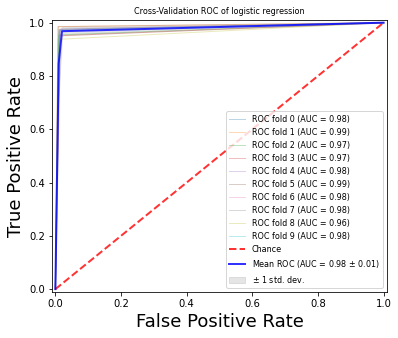

In [ ]:
#ROC_AUC
import sys
import numpy

kf = KFold(n_splits=10,shuffle=True)
tprs = []
aucs = []
fpr_lst=list()
tpr_lst=list()
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(6,5))
i = 0
for _ , _ in kf.split(X,y):
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test_lst[i],pred_values_lst[i] )
    #fpr, tpr, thresholds = roc_curve(Y_test_lst[i],pred_values_lst[i])
    fpr_lst.append(mean(fpr))
    tpr_lst.append(mean(tpr))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of logistic regression',fontsize=8)
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [ ]:
#recall/TPR

cv = KFold(n_splits=10, shuffle=True)#, shuffle=True, random_state=42
scores_recall = cross_val_score(model,X, y, scoring='recall', cv=cv)

print('scores_recall: %.3f (%.3f)' % (mean(scores_recall), std(scores_recall)))

scores_recall: 0.968 (0.009)


In [ ]:
# accracy

cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.984 (0.004)


In [ ]:
#precision

cv = KFold(n_splits=10, shuffle=True)#, shuffle=True, random_state=42
scores_precision = cross_val_score(model, X, y, scoring='precision', cv=cv)

print('scores_precision: %.3f (%.3f)' % (mean(scores_precision), std(scores_precision)))

scores_precision: 0.966 (0.008)
